In [8]:
import boto3

s3 = boto3.client('s3')
bucket_name = 'movierecc'
response = s3.list_objects_v2(Bucket=bucket_name)
print(response)


{'ResponseMetadata': {'RequestId': 'CNTW6YHRG4EPTRES', 'HostId': 'z4Vz7/K1m4EzTXWuvEHb5OdEuVPt7b4Xl9Vx8t0YuvQwHPmS9CIBfU5GoEYW+5/gGxjtlqvZ+VkAFBhTKIaMBYqYpNS2bAc0BR9rOQqt0bs=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'z4Vz7/K1m4EzTXWuvEHb5OdEuVPt7b4Xl9Vx8t0YuvQwHPmS9CIBfU5GoEYW+5/gGxjtlqvZ+VkAFBhTKIaMBYqYpNS2bAc0BR9rOQqt0bs=', 'x-amz-request-id': 'CNTW6YHRG4EPTRES', 'date': 'Fri, 06 Dec 2024 01:18:44 GMT', 'x-amz-bucket-region': 'us-east-1', 'content-type': 'application/xml', 'transfer-encoding': 'chunked', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'IsTruncated': False, 'Contents': [{'Key': 'movies_ratings.csv', 'LastModified': datetime.datetime(2024, 12, 4, 23, 43, 5, tzinfo=tzlocal()), 'ETag': '"dfea99f3a875181201b366a812e5b112-5"', 'Size': 69828720, 'StorageClass': 'STANDARD'}, {'Key': 'output/factorization-machines-2024-12-05-01-22-55-098/debug-output/training_job_end.ts', 'LastModified': datetime.datetime(2024, 12, 5, 1, 29, tzinfo=tzlocal()), 'ETag': '"99c79cc727ef

In [9]:
import sagemaker

import pandas as pd
import numpy as np
from sagemaker import get_execution_role

# Define SageMaker session and role
sagemaker_session = sagemaker.Session()
role = get_execution_role()


   movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating     timestamp  
0       3     4.0  9.449194e+08  
1       6     5.0  8.582755e+08  
2       8     4.0  8.339819e+08  
3      10     4.0  9.434979e+08  
4      11     4.5  1.230859e+09  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   movieId    1048575 non-null  int64  
 1   title      1048575 non-null  object 
 2   genres     1048575 non-null  object 
 3   userId

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


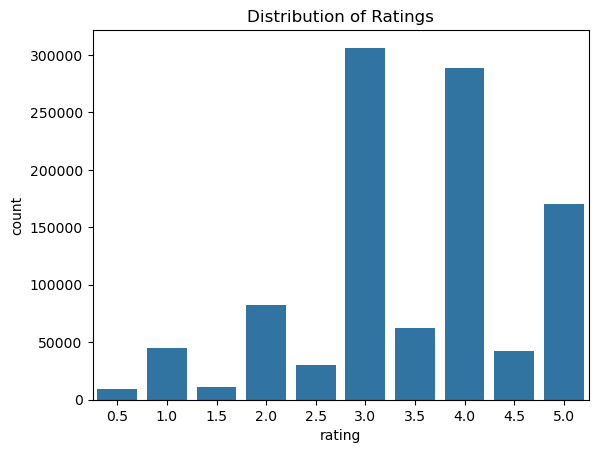

In [10]:
s3 = boto3.client('s3')
file_key = 'movies_ratings.csv'  

# Load the dataset into a Pandas DataFrame
response = s3.get_object(Bucket=bucket_name, Key=file_key)
data = pd.read_csv(response['Body'])

# Explore the data
print(data.head())
print(data.info())

# EDA: Distribution of Ratings
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=data, x='rating')
plt.title("Distribution of Ratings")
plt.show()


In [11]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   movieId    1048575 non-null  int64  
 1   title      1048575 non-null  object 
 2   genres     1048575 non-null  object 
 3   userId     1048575 non-null  int64  
 4   rating     1048574 non-null  float64
 5   timestamp  1048574 non-null  float64
dtypes: float64(2), int64(2), object(2)
memory usage: 48.0+ MB
None


In [12]:
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s', errors='coerce')  # Convert invalid timestamps to NaT

# Drop rows with NaT in 'timestamp'
data = data.dropna(subset=['timestamp'])

# Extract the year from the timestamp and store it in a new 'year' column
data['year'] = data['timestamp'].dt.year.astype(int)

# Display the first few rows of the updated dataset
print(data.head())

   movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating           timestamp  year  
0       3     4.0 1999-12-11 13:36:47  1999  
1       6     5.0 1997-03-13 17:50:52  1997  
2       8     4.0 1996-06-05 13:37:51  1996  
3      10     4.0 1999-11-25 02:44:47  1999  
4      11     4.5 2009-01-02 01:13:41  2009  


In [20]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048574 entries, 0 to 1048574
Data columns (total 7 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   movieId    1048574 non-null  int64         
 1   title      1048574 non-null  object        
 2   genres     0 non-null        float64       
 3   userId     1048574 non-null  int64         
 4   rating     1048574 non-null  float64       
 5   timestamp  1048574 non-null  datetime64[ns]
 6   year       1048574 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 64.0+ MB
None


In [ ]:
#XGBoost

/tmp/ipykernel_10556/1805675015.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


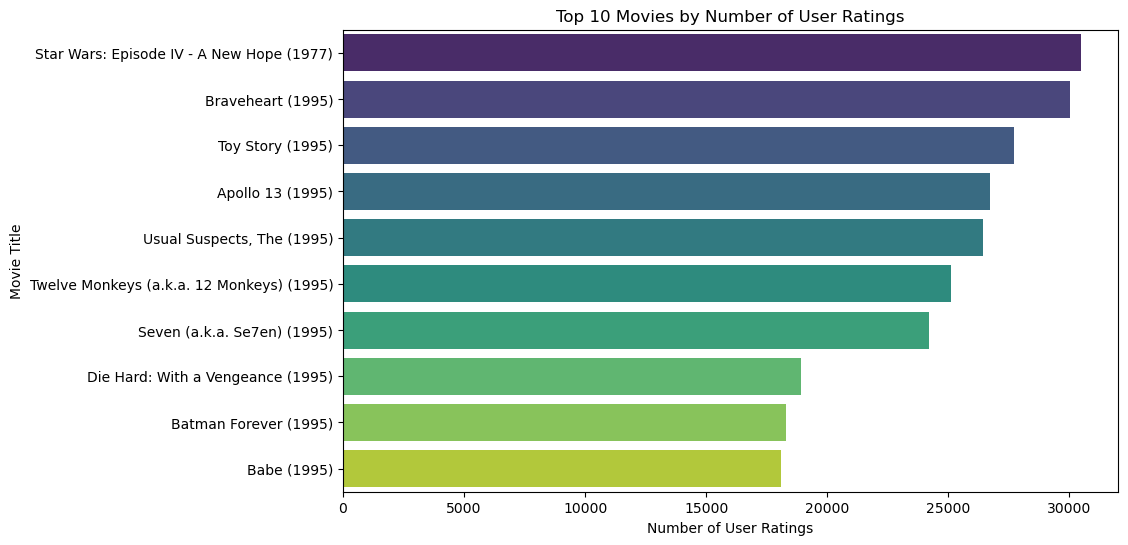

In [14]:
#EDA
movie_stats = data.groupby('title').agg(
    average_rating=('rating', 'mean'),
    rating_count=('rating', 'size')
).reset_index()


top_10_movies = movie_stats.sort_values(by='rating_count', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='rating_count',
    y='title',
    data=top_10_movies,
    palette='viridis'
)
plt.xlabel('Number of User Ratings')
plt.ylabel('Movie Title')
plt.title('Top 10 Movies by Number of User Ratings')
plt.show()


/tmp/ipykernel_10556/3546748801.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_10556/3546748801.py:7: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(


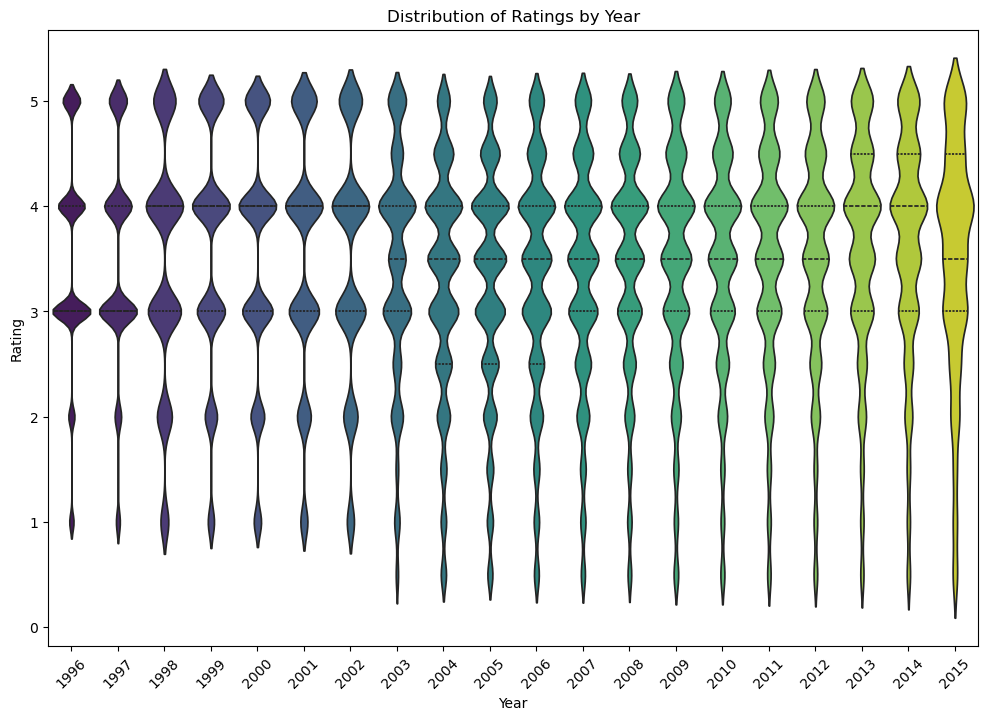

In [15]:
#EDA-2
ratings_by_year = data.groupby('year')['rating'].count()
filtered_years = ratings_by_year[ratings_by_year > 100].index  # Minimum 100 ratings per year
data_filtered = data[data['year'].isin(filtered_years)]

# Create the violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(
    x='year',
    y='rating',
    data=data_filtered,
    scale='width',
    inner='quartile',
    palette='viridis'
)
plt.title('Distribution of Ratings by Year')
plt.xlabel('Year')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.show()

/tmp/ipykernel_8733/2487702007.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


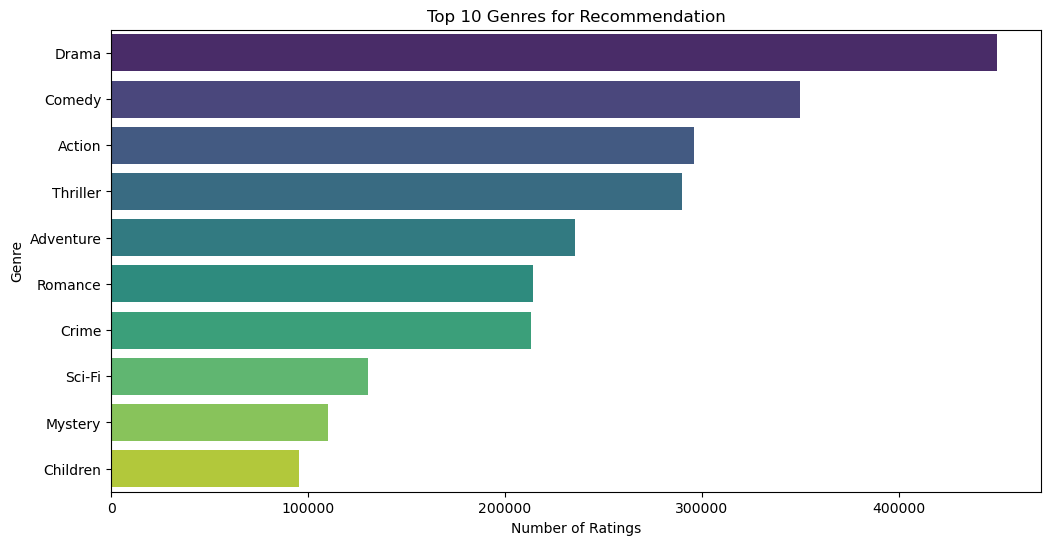

In [20]:
#EDA-3
genre_data = data[['genres', 'rating']].copy()
genre_data = genre_data.dropna()  # Handle missing genres if any
genre_data['genres'] = genre_data['genres'].str.split('|')
genre_data = genre_data.explode('genres')

# Count the number of ratings for each genre
genre_stats = genre_data.groupby('genres').agg(
    rating_count=('rating', 'size'),
    average_rating=('rating', 'mean')
).reset_index()

# Sort genres by the number of ratings in descending order
top_10_genres = genre_stats.sort_values(by='rating_count', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(
    x='rating_count',
    y='genres',
    data=top_10_genres,
    palette='viridis'
)
plt.xlabel('Number of Ratings')
plt.ylabel('Genre')
plt.title('Top 10 Genres for Recommendation')
plt.show()


In [13]:
# Preprocessing the dataset
data = data.dropna(subset=['rating'])  # Drop rows with missing ratings
data['genres'] = data['genres'].str.split('|')  # Split genres into lists
data = data.explode('genres')  # Explode genre lists into separate rows

# Encode genres into numeric labels
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['genre_encoded'] = label_encoder.fit_transform(data['genres'])

# Features: 'genre_encoded', Target: 'rating'
X = data[['genre_encoded']]
y = data['rating']

# Split into training and testing datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
# Save datasets as CSV files
X_train['rating'] = y_train
X_test['rating'] = y_test

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_file = 'train.csv'
test_file = 'test.csv'

train_data.to_csv(train_file, index=False, header=False)
test_data.to_csv(test_file, index=False, header=False)

# Upload to S3
s3 = boto3.client('s3')

s3.upload_file(train_file, bucket_name, 'train/train.csv')
s3.upload_file(test_file, bucket_name, 'test/test.csv')


In [19]:
import boto3
import pandas as pd
from sagemaker import get_execution_role, Session
from sagemaker.inputs import TrainingInput
from sagemaker.estimator import Estimator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Preprocessing the dataset
data = data.dropna(subset=['rating'])  # Drop rows with missing ratings
data['genres'] = data['genres'].str.split('|')  # Split genres into lists
data = data.explode('genres')  # Explode genre lists into separate rows

# Encode genres into numeric labels
label_encoder = LabelEncoder()
data['genre_encoded'] = label_encoder.fit_transform(data['genres'])

# Features: 'genre_encoded', Target: 'rating'
X = data[['genre_encoded']]
y = data['rating']

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save datasets as CSV files for SageMaker
train_file = 'train.csv'
test_file = 'test.csv'

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

train_data.to_csv(train_file, index=False, header=False)
test_data.to_csv(test_file, index=False, header=False)

# Upload data to S3
s3.upload_file(train_file, bucket_name, 'train/train.csv')
s3.upload_file(test_file, bucket_name, 'test/test.csv')

# Define the XGBoost container
container = sagemaker.image_uris.retrieve("xgboost", boto3.Session().region_name, version="latest")

# Configure the estimator
xgboost_estimator = Estimator(
    container,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket_name}/output',
    sagemaker_session=sagemaker_session
)

# Set hyperparameters
xgboost_estimator.set_hyperparameters(
    objective='reg:linear',  # Use 'reg:linear' for regression tasks in this XGBoost version
    num_round=100
)

# Define training input
train_input = TrainingInput(
    s3_data=f's3://{bucket_name}/train/train.csv',
    content_type="csv"
)

# Train the model
xgboost_estimator.fit({'train': train_input})

# Deploy the model
xgboost_predictor = xgboost_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large'
)




INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: xgboost-2024-12-06-01-39-27-046


2024-12-06 01:39:28 Starting - Starting the training job...
2024-12-06 01:39:43 Starting - Preparing the instances for training...
2024-12-06 01:40:14 Downloading - Downloading input data...
2024-12-06 01:41:00 Downloading - Downloading the training image.....Arguments: train
[2024-12-06:01:41:39:INFO] Running standalone xgboost training.
[2024-12-06:01:41:39:INFO] Path /opt/ml/input/data/validation does not exist!
[2024-12-06:01:41:39:INFO] File size need to be processed in the node: 12.92mb. Available memory size in the node: 155.61mb
[2024-12-06:01:41:39:INFO] Determined delimiter of CSV input is ','
[01:41:39] S3DistributionType set as FullyReplicated
[01:41:40] 2136632x1 matrix with 2136632 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[01:41:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 16 extra nodes, 0 pruned nodes, max_depth=5
[0]#011train-rmse:7.49135
[01:41:40] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 18 ext

INFO:sagemaker:Creating model with name: xgboost-2024-12-06-01-42-44-564


Training seconds: 125
Billable seconds: 125


INFO:sagemaker:Creating endpoint-config with name xgboost-2024-12-06-01-42-44-564
INFO:sagemaker:Creating endpoint with name xgboost-2024-12-06-01-42-44-564


------!

In [20]:
# Prepare sample input data
sample_data = X_test.head(5).to_csv(header=False, index=False)  # Convert input to CSV string

# Make predictions
response = xgboost_predictor.predict(sample_data, initial_args={"ContentType": "text/csv"})

# Parse and print the response
print(response.decode("utf-8"))  # Decode the response if it is in bytes


7.969473361968994,7.813945770263672,7.969473361968994,6.402626037597656,7.969473361968994


In [42]:
from sklearn.metrics import mean_squared_error
predictions = [0.969473361968994, 7.813945770263672, 7.969473361968994, 6.402626037597656, 7.969473361968994]
actual_ratings = y_test.head(5).values

# Calculate RMSE
rmse = mean_squared_error(actual_ratings, predictions, squared=False)
print(f"RMSE: {rmse}")


RMSE: 3.7354068467647297


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [29]:

# Save recommendations to a text file
output_file = "recommendations.txt"

with open(output_file, "w") as f:
    for genre, movies in recommendations_by_genre.items():
        f.write(f"\nTop 10 Recommendations for Genre: {genre}\n")
        for movie_id, predicted_rating in movies:
            title = data[data['movieId'] == movie_id]['title'].iloc[0]
            f.write(f"Movie ID: {movie_id}, Title: {title}, Predicted Rating: {predicted_rating:.2f}\n")


In [30]:
bucket_name = "movierecc"
s3_key = "outputlogs/recommendations.txt"

# Upload the file to S3
s3.upload_file(output_file, bucket_name, s3_key)

print(f"File successfully uploaded to s3://{bucket_name}/{s3_key}")


File successfully uploaded to s3://movierecc/outputlogs/recommendations.txt


In [32]:


# Prepare the recommendations as a list of dictionaries
recommendations_list = []
for genre, movies in recommendations_by_genre.items():
    for movie_id, predicted_rating in movies:
        title = data[data['movieId'] == movie_id]['title'].iloc[0]
        recommendations_list.append({"Genre": genre, "Movie ID": movie_id, "Title": title, "Predicted Rating": predicted_rating})

# Convert to DataFrame
recommendations_df = pd.DataFrame(recommendations_list)

# Save as CSV locally
csv_file = "recommendations.csv"
recommendations_df.to_csv(csv_file, index=False)

# Upload the CSV to S3
s3_key_csv = "outputlogs/recommendations.csv"
s3.upload_file(csv_file, bucket_name, s3_key_csv)

print(f"CSV file successfully uploaded to s3://{bucket_name}/{s3_key_csv}")


CSV file successfully uploaded to s3://movierecc/outputlogs/recommendations.csv


In [ ]:
import boto3
import time

# Initialize CloudWatch Logs client
logs_client = boto3.client("logs")

# Define log group and stream
log_group_name = "CustomLogGroup"
log_stream_name = "NotebookLogs"

# Create log group (if it doesn't exist)
try:
    logs_client.create_log_group(logGroupName=log_group_name)
except logs_client.exceptions.ResourceAlreadyExistsException:
    pass  # Log group already exists

# Create log stream (if it doesn't exist)
try:
    logs_client.create_log_stream(logGroupName=log_group_name, logStreamName=log_stream_name)
except logs_client.exceptions.ResourceAlreadyExistsException:
    pass  # Log stream already exists

# Send log message
log_message = f"Log entry at {time.ctime()}: SageMaker workflow started."
response = logs_client.put_log_events(
    logGroupName=log_group_name,
    logStreamName=log_stream_name,
    logEvents=[
        {
            "timestamp": int(round(time.time() * 1000)),  # Milliseconds since epoch
            "message": log_message
        }
    ]
)

print("Log sent to CloudWatch:", response)


In [ ]:
import boto3
import time

# Initialize CloudWatch client
cloudwatch = boto3.client("cloudwatch")

# Send custom metric
response = cloudwatch.put_metric_data(
    Namespace="SageMaker/CustomMetrics",  # Custom namespace
    MetricData=[
        {
            "MetricName": "DataProcessingTime",  # Name of the metric
            "Dimensions": [
                {"Name": "Workflow", "Value": "Preprocessing"}
            ],
            "Timestamp": time.time(),
            "Value": 120.5,  # Metric value
            "Unit": "Seconds"
        }
    ]
)

print("Metric sent to CloudWatch:", response)


In [ ]:
from sagemaker import Model

model = Model(model_data="s3://your-model-path/model.tar.gz", role="SageMakerRole")
predictor = model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name="your-endpoint-name",
    enable_network_isolation=False,
    data_capture_config={
        "EnableCapture": True,
        "DestinationS3Uri": "s3://your-bucket/data-capture",
        "InitialSamplingPercentage": 100,
        "CaptureOptions": [{"CaptureMode": "Output"}],
    },
)


In [31]:
import boto3
from datetime import datetime

# Initialize SageMaker client
sagemaker_client = boto3.client('sagemaker')

# List all endpoints
response = sagemaker_client.list_endpoints()

# Print endpoint details
for endpoint in response['Endpoints']:
    name = endpoint['EndpointName']
    status = endpoint['EndpointStatus']
    creation_time = endpoint['CreationTime']
    print(f"Endpoint Name: {name}, Status: {status}, Created At: {creation_time}")


Endpoint Name: xgboost-2024-12-06-01-42-44-564, Status: InService, Created At: 2024-12-06 01:42:45.806000+00:00
Endpoint Name: xgboost-2024-12-06-01-32-13-223, Status: InService, Created At: 2024-12-06 01:32:14.514000+00:00
Endpoint Name: sagemaker-xgboost-2024-12-06-01-14-07-685, Status: InService, Created At: 2024-12-06 01:14:08.954000+00:00
Endpoint Name: sagemaker-xgboost-2024-12-06-00-31-17-168, Status: InService, Created At: 2024-12-06 00:31:18.425000+00:00


In [32]:
import boto3
from datetime import datetime

# Initialize SageMaker client
sagemaker_client = boto3.client('sagemaker')

# List all endpoints
response = sagemaker_client.list_endpoints()

# Sort endpoints by creation time (most recent first)
endpoints = sorted(
    response['Endpoints'],
    key=lambda x: x['CreationTime'],
    reverse=True
)

# Display sorted endpoints
print("Sorted Endpoints by Creation Time:")
for endpoint in endpoints:
    name = endpoint['EndpointName']
    status = endpoint['EndpointStatus']
    creation_time = endpoint['CreationTime']
    print(f"Endpoint Name: {name}, Status: {status}, Created At: {creation_time}")


Sorted Endpoints by Creation Time:
Endpoint Name: xgboost-2024-12-06-01-42-44-564, Status: InService, Created At: 2024-12-06 01:42:45.806000+00:00
Endpoint Name: xgboost-2024-12-06-01-32-13-223, Status: InService, Created At: 2024-12-06 01:32:14.514000+00:00
Endpoint Name: sagemaker-xgboost-2024-12-06-01-14-07-685, Status: InService, Created At: 2024-12-06 01:14:08.954000+00:00
Endpoint Name: sagemaker-xgboost-2024-12-06-00-31-17-168, Status: InService, Created At: 2024-12-06 00:31:18.425000+00:00


In [33]:
# Get all endpoints and sort by creation time
endpoints = sorted(
    response['Endpoints'],
    key=lambda x: x['CreationTime'],  # Sort by creation time
    reverse=True                      # Most recent first
)

# Keep only the top 1 endpoint, delete the rest
for endpoint in endpoints[1:]:
    endpoint_name = endpoint['EndpointName']
    sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
    print(f"Deleted endpoint: {endpoint_name}")


Deleted endpoint: xgboost-2024-12-06-01-32-13-223
Deleted endpoint: sagemaker-xgboost-2024-12-06-01-14-07-685
Deleted endpoint: sagemaker-xgboost-2024-12-06-00-31-17-168


In [30]:
import boto3
sagemaker_client = boto3.client('sagemaker')

response = sagemaker_client.list_endpoints()
for endpoint in response['Endpoints']:
    print(endpoint['EndpointName'], endpoint['EndpointStatus'])


xgboost-2024-12-06-01-42-44-564 InService
xgboost-2024-12-06-01-32-13-223 InService
sagemaker-xgboost-2024-12-06-01-14-07-685 InService
sagemaker-xgboost-2024-12-06-00-31-17-168 InService
